# Plot script for figure 5

In [1]:
import os
import intake
import numpy as np
import xarray as xr
import matplotlib as mpl
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import easygems.healpix as egh
import healpy 

from healpix_plot import default_plot, get_diverging_colormap, plot_polygon
from healpix_functions import evaluate_against_coarse_xarray
path = 'data'
figpath = 'figures_paper'

mpl.rc('font', **{'size': 8})
proj = ccrs.Mollweide()
proj._threshold /= 1000.  # ensure a smooth polygon
cm = 1/2.54  # centimeters in inches

ERROR 1: PROJ: proj_create_from_database: Open of /home/b/b381815/miniconda3/envs/py/share/proj failed


In [2]:
txx_z9 = xr.open_dataset(os.path.join(
    path, 'ICON-ngc4008', 'z9', 'txx_ann_ICON-ngc4008_ssp370_zoom9.nc'))['txx']
txx_z6 = xr.open_dataset(os.path.join(
    path, 'ICON-ngc4008', 'z6', 'txx_ann_ICON-ngc4008_ssp370_zoom6.nc'))['txx']

txx_z9 = txx_z9.drop(['lon', 'lat', 'crs'])
txx_z6 = txx_z6.drop(['lon', 'lat', 'crs'])

txx_anom = evaluate_against_coarse_xarray(txx_z9, txx_z6).mean('time')

cat = intake.open_catalog("https://data.nextgems-h2020.eu/catalog.yaml")
topography = cat.ICON.ngc4008(use_cftime=True, time='P1D', zoom=9).to_dask()['zg'].isel(level_full=-1)

pop = xr.open_dataset('/work/uc1275/LukasBrunner/ppp_2020_1km_Aggregated.nc')['band_data'].squeeze()

/tmp/ipykernel_4076022/610291633.py:6: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  txx_z9 = txx_z9.drop(['lon', 'lat', 'crs'])
/tmp/ipykernel_4076022/610291633.py:7: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  txx_z6 = txx_z6.drop(['lon', 'lat', 'crs'])
/home/b/b381815/miniconda3/envs/py/lib/python3.12/site-packages/intake_xarray/base.py:21: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  'dims': dict(self._ds.dims),


In [3]:
# just for the boxplots
txx_z9_ifs = xr.open_dataset(os.path.join(
    path, 'IFS-9-FESOM-5-production', 'z9', 'txx_ann_IFS-9-FESOM-5-production_ssp370_zoom9.nc'))['txx']
txx_z6_ifs = xr.open_dataset(os.path.join(
    path, 'IFS-9-FESOM-5-production', 'z6', 'txx_ann_IFS-9-FESOM-5-production_ssp370_zoom6.nc'))['txx']


In [4]:
city_coordinates = {
    'Mumbai': [72 + (52 + 39/60)/60, 19 + (4 + 34/60)/60],  # lon, lat
    'Chennai': [80 + (16 + 30/60)/60, 13 + (4 + 57/60)/60],
    'Karachi': [67 + (36/60)/60, 24 + (51 + 36/60)/60],
    'Kathmandu': [85 + (19 + 12/60)/60, 27 + (42 + 36/60)/60],
}

ylim_dict = {
    'Karachi': [5, 15],
    'Mumbai': [2, 6],
    'Chennai': [2, 7],
    'Kathmandu': [-11, -5],
}

In [5]:
idx_fine = {}
idx_coarse = {}
center_fine = {}
corners_coarse = {}
for city in city_coordinates:
    idx = healpy.ang2pix(healpy.order2nside(6), *city_coordinates[city], nest=True, lonlat=True)
    idx_coarse[city] = idx

    corners = healpy.boundaries(healpy.order2nside(6), idx, nest=True, step=1)
    (phi, lon) = np.rad2deg(healpy.vec2ang(np.transpose(corners)))
    lat = 90 - phi
    corners_coarse[city] = [  # extend polygon a bit so the line does not overlapp with the content
        [lo - .15 if lo == np.min(lon) else (lo + .15 if lo == np.max(lon) else lo), 
        la - .15 if la == np.min(lat) else (la + .15 if la == np.max(lat) else la),
        ] for lo, la in zip(lon, lat)]

    idx = healpy.ang2pix(healpy.order2nside(9), *city_coordinates[city], nest=True, lonlat=True)
    idx_fine[city] = idx
    
    lon, lat= healpy.pix2ang(healpy.order2nside(9), idx, nest=True, lonlat=True)  # coords of the closest pixel
    center_fine[city] = (lon, lat)

city_label_coords = {
    'Karachi': [61, 21],
    'Mumbai': [66, 15],
    'Chennai': [84, 11],
    'Kathmandu': [85, 17],
}

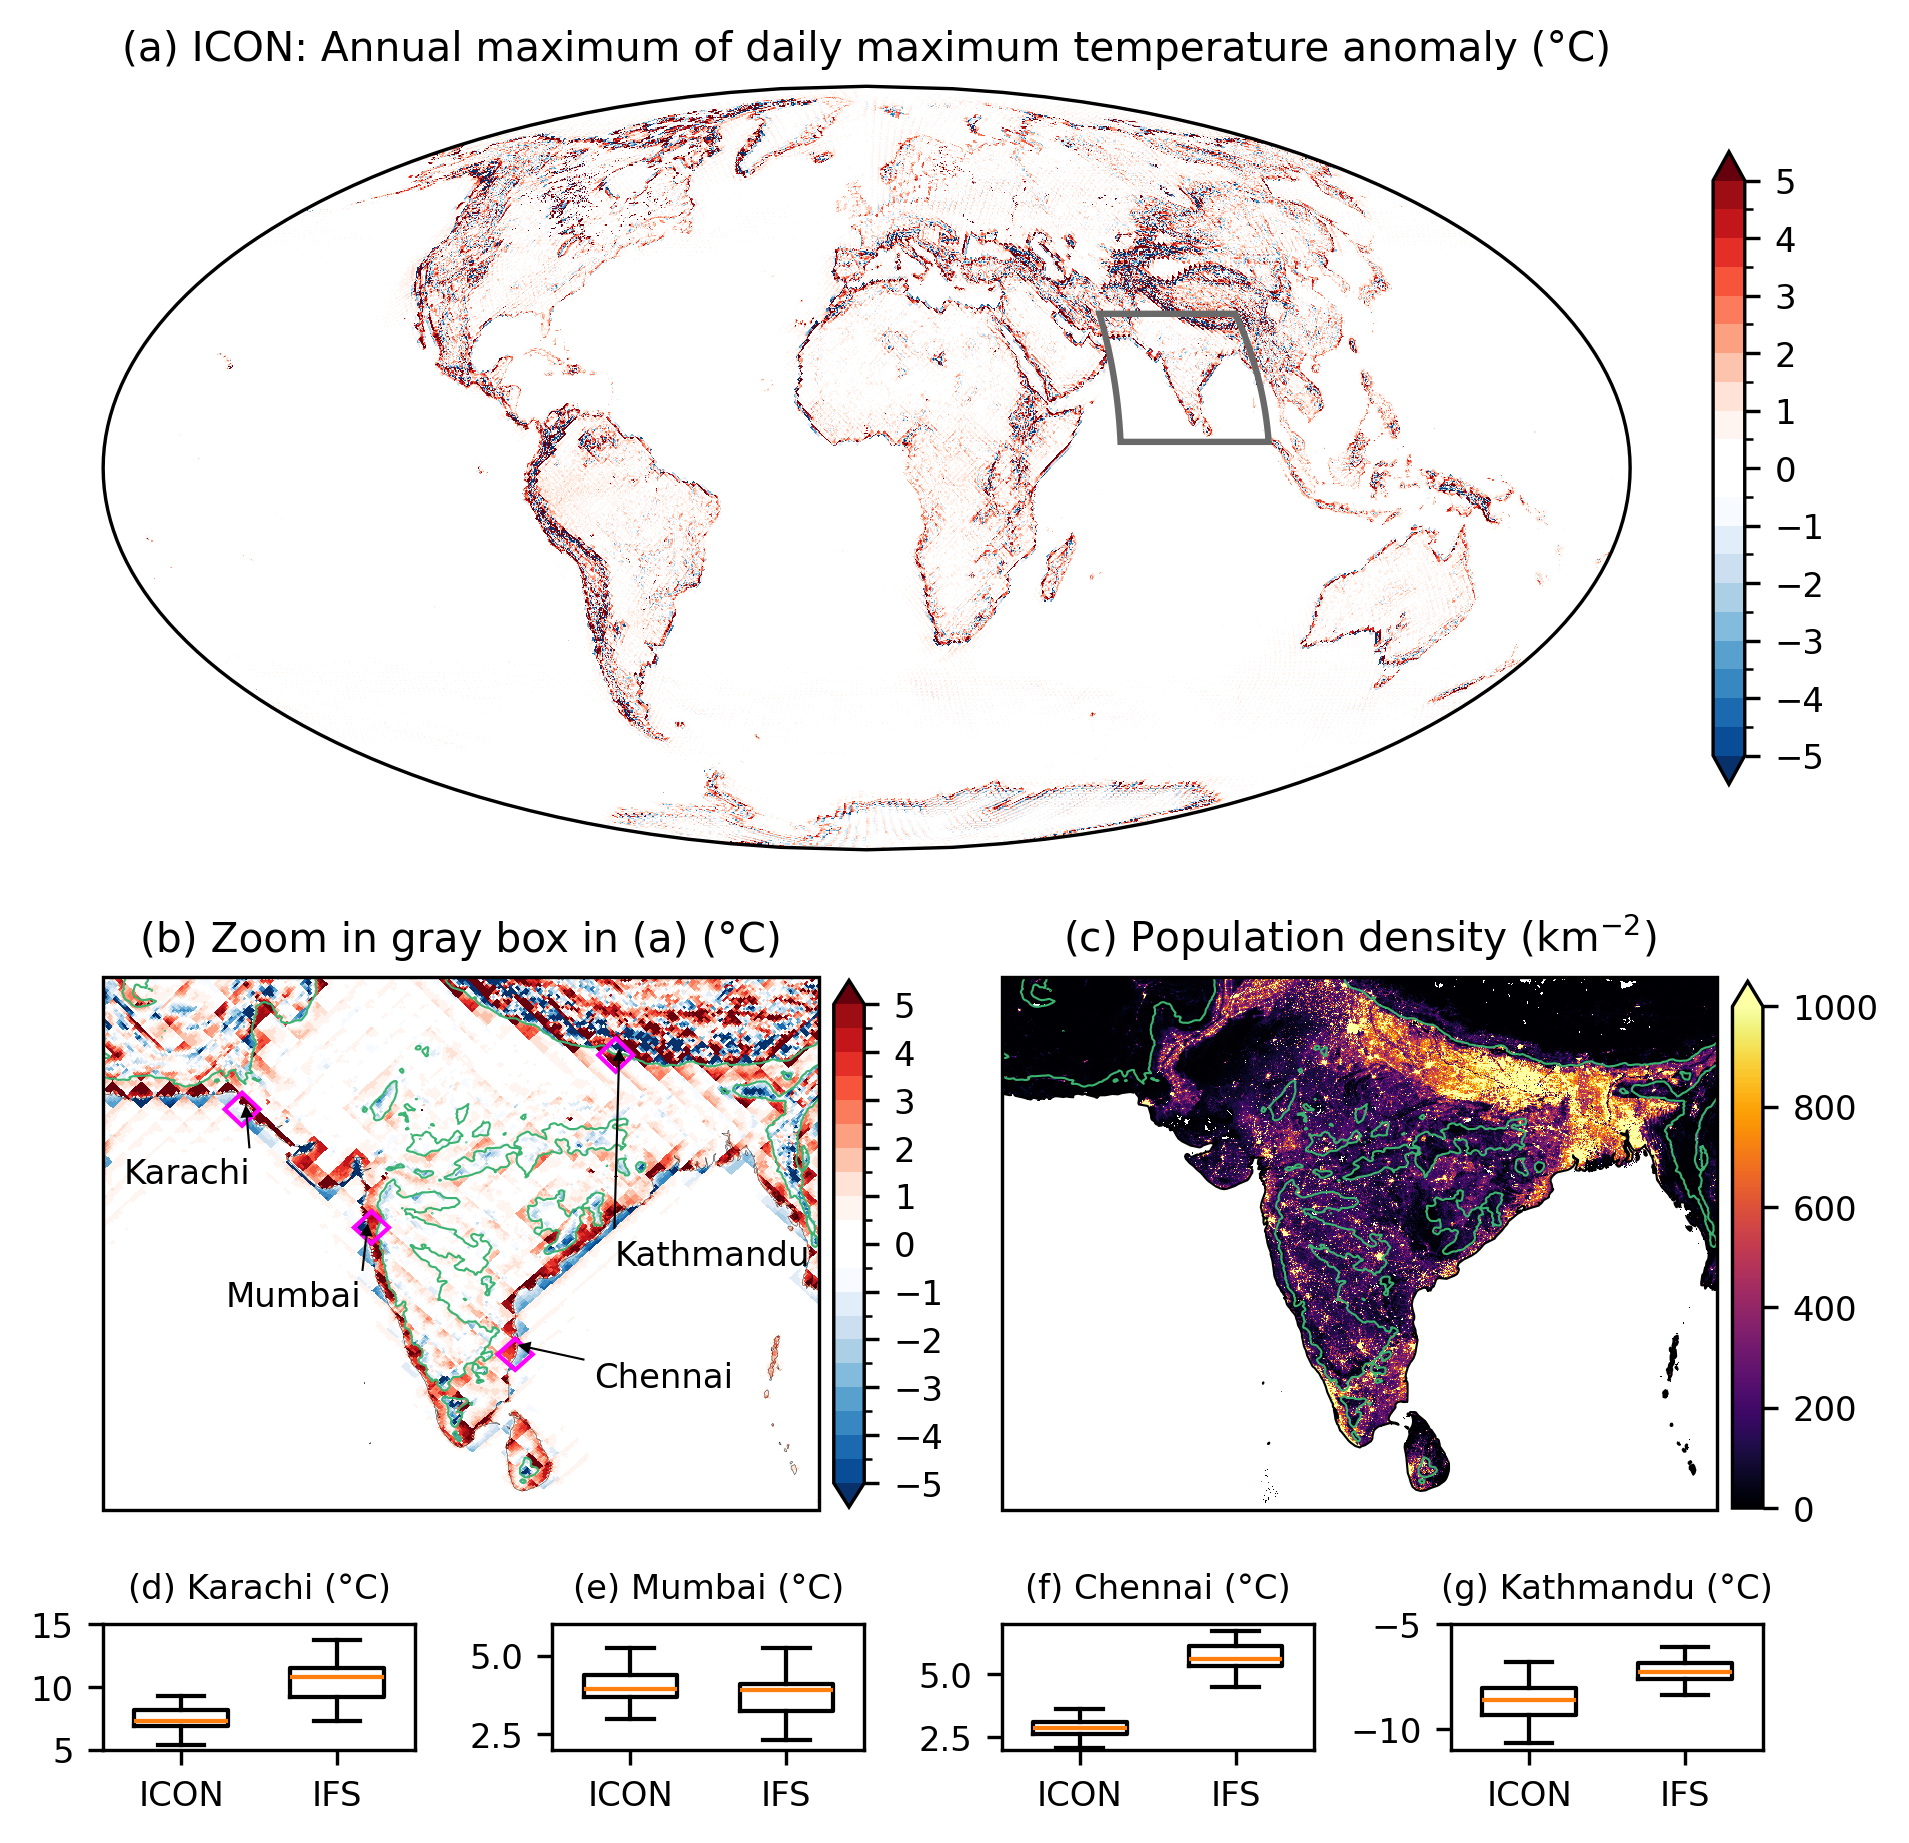

In [6]:
dpi = 305

fig, axes = plt.subplot_mosaic(
    """
    AAAA
    AAAA
    AAAA
    AAAA
    BBCC
    BBCC
    BBCC
    DEFG
    """,
    figsize=(16*cm, 15.5*cm),
    dpi=dpi,
    per_subplot_kw={
        'A': {'projection': proj},
        'B': {'projection': ccrs.PlateCarree()},
        'C': {'projection': ccrs.PlateCarree()},
    }
)
# fig.subplots_adjust(hspace=.1)

# --- A: global map of sub-grid anomaly from ICON ---
ax = axes['A']
ax.set_title('(a) ICON: Annual maximum of daily maximum temperature anomaly (°C)')
ax.set_global()
levels = np.arange(-5, 5.1, .5)
default_plot(
    txx_anom, 
    ax=ax,
    cmap=get_diverging_colormap(levels, return_colors=True, extend='both'),
    levels=levels,
    extend='both',
    cbar_kwargs={'ticks': np.arange(-5, 6, 1)},
    add_coastlines=False,
)

plot_polygon(
    ax=ax,
    corners=[(60, 5), (95, 5), (95, 30), (60, 30)],
    lw=1.5,
    edgecolor='dimgray',
)

# --- B: zoom in to sub-grid anomaly from ICON ---
ax = axes['B']
ax.set_title('(b) Zoom in gray box in (a) (°C)')
ax.set_extent([60, 95, 5, 30])
levels = np.arange(-5, 5.1, .5)
_, _, map_ = default_plot(
    txx_anom, 
    ax=ax,
    cmap=get_diverging_colormap(levels, return_colors=True, extend='both'),
    add_colorbar=False,
    levels=levels,
    extend='both',

    topography=topography,
    topography_kwargs=dict(
        levels=[500],
        colors='mediumseagreen',
        linewidths=.5,
    ),
)
plt.colorbar(map_, ax=ax, shrink=1, fraction=.04, aspect=17.3, extend='both', pad=.02, ticks=np.arange(-5, 6, 1))

# print outlines of coarse grid cells represeting different cities
for city, corners in corners_coarse.items():
    plot_polygon(
        ax=ax,
        corners=corners,
        lw=1,
        edgecolor='magenta',
    )

# print arrows pointing to the center of the fine grid cell representing different cities
for city, center in center_fine.items():
    ax.annotate(
        city,
        center,
        city_label_coords[city],
        arrowprops=dict(facecolor='black', edgecolor='none', width=.5, headwidth=3, headlength=3, shrink=0.01),
        zorder=99,
    )

# --- C: population density for same region as B ---
ax = axes['C']
ax.set_extent([60, 95, 5, 30])
ax.coastlines(color='k', lw=.5)

map_ = pop.plot(
    ax=ax, 
    vmin=0, 
    vmax=1000,
    cmap='inferno',
    robust=True,
    add_colorbar=False,
    rasterized=True,
)
ax.set_title('(c) Population density (km$^{-2}$)')
plt.colorbar(map_, ax=ax, shrink=1, fraction=.04, aspect=17.3, extend='max', pad=.02)

# - topography lines - 
_, _, nx, ny = np.array(ax.bbox.bounds, dtype=int)
xlims = ax.get_xlim()
ylims = ax.get_ylim() 
im = egh.healpix_resample(
    topography, 
    xlims, ylims, 
    nx, ny, 
    ax.projection, 
    method='linear', 
    nest=True,
)

ax.contour(
    im, 
    extent=xlims + ylims, 
    origin="lower",
    levels=[500],
    colors='mediumseagreen',
    linewidths=.5,
)
# ---

# --- D, E, F, G: barplots ---
for key, city in zip(['D', 'E', 'F', 'G'], ['Karachi', 'Mumbai', 'Chennai', 'Kathmandu']):
    ax = axes[key]
    ax.set_title('({}) {} (°C)'.format(key.lower(), city), fontsize='medium')
    ax.boxplot([
        txx_z9.isel(cell=idx_fine[city]) - txx_z6.isel(cell=idx_coarse[city]),
        txx_z9_ifs.isel(cell=idx_fine[city]) - txx_z6_ifs.isel(cell=idx_coarse[city]),
    ],
    widths=.6,
    showfliers=False,
    )
    ax.set_ylim(ylim_dict[city])
    ax.set_xticklabels(['ICON', 'IFS'])

fig.tight_layout()
fig.savefig(os.path.join(figpath, 'figure5.png'), dpi=dpi)
fig.savefig(os.path.join(figpath, 'figure5.pdf'), dpi=dpi)